In [2]:
from Crypto.Util.number import getPrime, isPrime, sieve_base
import random

In [1]:
def jacobi_symbol(a, n):
    if a ==0:
        return 0
    if a ==1:
        return 1
    #write a = 2^e *s where a1 is odd
    e =0
    a1 = a
    while a1 & 1==0: #while a1 is even
        a1>>=1
        e+=1
        
    #if e is even set s = 1
    if e & 1 == 0:
        s = 1
    elif n % 8 == 7 or n % 8 == 1:
        s = 1
    elif n % 8 == 3 or n % 8 == 5:
        s = -1
    
    if n % 4 == 3 and a1 % 4 == 3:
        s = -s
        
    n1 = n % a1
    if a1 ==1:
        return s
    else:
        return s * jacobi_symbol(n1, a1)

# Prerequisites

- Fermat's test
- Number theory basics

# Theory

https://www.youtube.com/watch?v=S3vNCMTEXQM

First, suppose $p$ is prime, and consider the modular equation $x^2 \equiv 1 \pmod{p}$. 

What are the solutions to this equation? 
- We know that $x^2 - 1 \equiv 0 \pmod{p} \iff (x-1)(x+1) \equiv 0 \pmod{p}$. 

Since $p$ is prime, $p$ has to divide either $x-1$ or $x+1$ => $x \equiv \pm 1 \pmod{p}$

Let $p$ be an odd prime and write $p−1=2^rs$ with $s$ odd.  
Let $a$ be any number NOT divisible by $p$.
Then **one** of the following two conditions is true:
- $a^s \equiv 1 (mod \ p)$
- One of $a^s,a^{2s},a^{4s},...,a^{2^{r−1}s} \equiv  −1 \bmod p$

Miller rabin test uses the contrapositive of this
- if for some $a$ neither of the above holds => $p$ is not prime


**Remarks**:
- (Monier-Rabin Bound): For $n \neq 9$ odd and composite the number of strong liars $|L(n)| \leq \dfrac {\phi(n)} 4$
- (number of strong liars) For most composite integers $n$, the number of strong liars for $n$ is actually much smaller than the theoretical upper bound of $φ(n)/4$. Consequently, the Miller-Rabin error-probability bound is much smaller
- (fixed bases in Miller-Rabin) If $a_1$ and $a_2$ are strong liars for $n$, their product $a_1\cdot a_2$ is very likely, but not certain, to also be a strong liar for $n$.  A strategy that is sometimes employed is to fix the bases $a$ in the Miller-Rabin algorithm to be the first few primes(composite bases are ignored because of the preceding statement), instead of choosing them at random

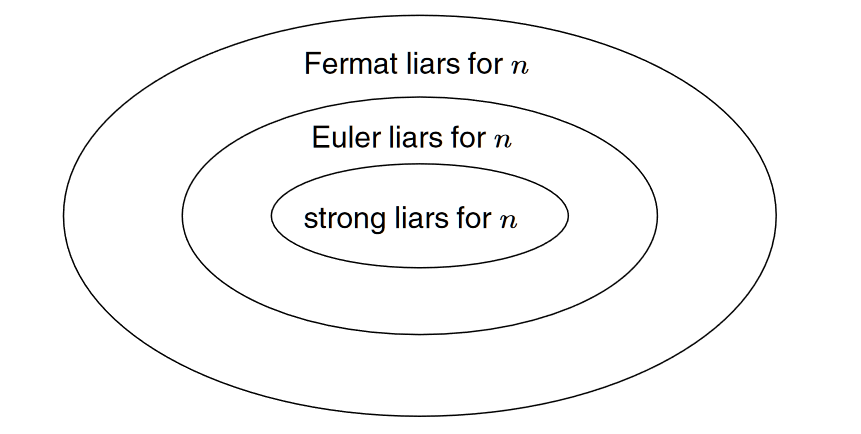

# Code

In [3]:
def miller_rabin_test(n, k):
    '''returns Composite or Probably prime'''
    
    #check parity
    if not n & 1:
        return 'Composite'
    
    r = 0
    s = n-1
    #write n-1 = 2^r*s
    while not s & 1:
        s = s>>1
        r+=1
    assert(pow(2, r)* s == n-1)
    
    for i in range(k):
        a = random.randint(2, n-2)
        x = pow(a, s, n)
        if x == 1 or x == n-1:
            continue #search for another witness
        for _ in range(r):
            x = pow(x, 2, n)
            if x == n-1:
                break 
        else:
             #if it doesnt break, neither condition is satisfied =>  this executes => we found a composite
            return "Composite"
    return "Probably prime"
    

In [4]:
print(miller_rabin_test(2403, 100))
p = getPrime(512)
print(miller_rabin_test(p, 100))
print(miller_rabin_test(561, 100))

Composite
Probably prime
Composite


# Breaking Miller-Rabin 

- https://eprint.iacr.org/2018/749.pdf


## Fixed bases -> Arnault method

In [5]:
def miller_rabin_test_fixed(n, a_list):
    '''returns Composite or Probably prime'''
    
    #check parity
    if not n & 1:
        return 'Composite'
    
    r = 0
    s = n-1
    #write n-1 = 2^r*s
    while not s & 1:
        s = s>>1
        r+=1
    assert(pow(2, r)* s == n-1)
    
    for a in a_list:
        x = pow(a, s, n)
        if x == 1 or x == n-1:
            continue #search for another witness
        for _ in range(r):
            x = pow(x, 2, n)
            if x == n-1:
                break 
        else:
             #if it doesnt break, neither condition is satisfied =>  this executes => we found a composite
            return "Composite"
    return "Probably prime"
    

- https://core.ac.uk/download/pdf/81930829.pdf
- https://www.jointmathematicsmeetings.org/mcom/1995-64-209/S0025-5718-1995-1260124-2/S0025-5718-1995-1260124-2.pdf

Let $n = p_1p_2..p_h$
Define: 
- $k_i  = \cfrac {p_i - 1} {p_1 - 1}$
- $m_i = \cfrac {\Pi_{j \neq i} {p_j - 1}} {p_1 - 1} \forall 1 \leq i \leq h$

If $k_i, m_i \in \mathbb{Z} \ \forall 2 \leq i \leq h => n$ is a Carmichael number

(The law of quadratic reciprocity) If $p$ and $q$ are distinct odd primes, we have
$\left(\dfrac{q}{p}\right)\left(\dfrac{p}{q}\right)=(-1)^{\frac{p-1}{2} \frac{q-1}{2}}$


Additional proprieties:
- if $\gcd(a, n) = 1$ and $\left(\dfrac a {p_i} \right)= -1$ for all $1 \leq i \leq h$ then $a$ will be a Miller Rabin non-witness with respect to $n$ 
- for any prime $p$,  $\left(\dfrac a {p}\right)$ can be determined from $\left(\dfrac p a\right)$ and the values of $a \bmod 4$ and $p \bmod 4$ => for each a we can compute the set $S_a$ of possible non-residues mod $4a$ of potential primes $p$
    $$S_a \text{ satisfying } \left(\dfrac a {p}\right) = -1 \iff p \bmod 4a \in S_a$$
    
Starting with some $p_1$ we can determine the other $p_i$ of the form $p_i = k_i(p_1 - 1)+ 1$ for all $1 \leq i \leq h => $ $$k_i(p_1 - 1) + 1 \bmod 4a \in S_a \ \forall 1\leq i \leq h$$

If the coeff $k_i$ are coprime to $a$ then the condition becomes:$$p_1 \bmod 4a∈⋂^h_{i=1}k^{−1}_i(S_a+k_i−1)$$ where $k^{−1}_i(S_a+k_i−1)$ is the set $\{k^{−1}_i(s+k_i−1) | s \in S_a\}$ => We have a set of conditions for the values of $p_1$ for each $a$

So for each value of $a$ we have a few candidates in our subset from $S_a$. We select one of these candidates $z_a$ for each $a \in A$ and using the CRT we can combine these conditions into a single one $p_1 \bmod \text{lcm}(4, a_1, .. a_h)$ 

The $k_i$ are a set of primes usually smaller than $\max(A)$ such that $k_i^{-1}$ exists mod $4a$

**Algorithm**:
- Generate the set $S_a$ of residues modulo $4a$ of primes $p$ s.t $\left(\dfrac a {p}\right) = -1$ for each base $a$
- Select $k_i$ coprime to all $a$
- Find the subsets that meet the condition 
    - $p_1 \bmod 4a∈⋂^h_{i=1}k^{−1}_i(S_a+k_i−1)$
- Choose 1 residue / set => $z_a$ (arbitrary but not all combinations will lead to a solution)
- Verify additional conditions:
    - for $h = 3 $
        - $p_1 \equiv k_3^{-1} \bmod k_2$
        - $p_1 \equiv k_2^{-1} \bmod k_3$
- Use CRT with all the conditions 
    - $p_1 = z \bmod \text{lcm}(4, a_1, ... a_h, k_2, ... k_h)$
- Compute $p_i = k_i(p_1 - 1) + 1$ such that all $p_i$ are prime.

## Fixed bases -> Bleichenbacher

https://www.semanticscholar.org/paper/Breaking-a-Cryptographic-Protocol-with-Pseudoprimes-Bleichenbacher/e9f1f083adc1786466d344db5b3d85f4c268b429?p2df

**(Korselt's Criterion)**: A composite integer $n$ is a Carmichael number if and only if the following two conditions are satisfied:
- $n$ is square-free, i.e., $n$ is not divisible by the square of any prime; 
- $p−1$ divides $n−1$ for every prime divisor $p$ of $n$

Erdos's idea to construct pseudoprimes
- Choose $M \in \mathbb{Z}$ that has many divisors
- Let $R$ be the set of primes $r$ such that $r−1$ is a divisor of $M$. 
- If a subset $T⊂R$ can be found such that
$$ C = \underset {r\in T}{\prod} r \equiv 1 \bmod M \ \ \ (1)$$
Then C is a Carmichael number because C satisfies the Korselt's criterion 

**Note**: One can hope to find such sets $$ if $R$ contains more than about $\log_2(M)$ primes


Additionally, a Carmichael number $C$ is a strong pseudoprime for a base $a$ if the order of $a$ modulo $r$ is divisible by the same power of 2 for all primes factors $r$ of $C$.  
If all prime factors $r$ are congruent 3 modulo 4 then this condition is satisfied when $a$ is a quadratic residue modulo either all prime factors $r$ or none at all, because in that case the order of $a$ modulor is either even or odd for all $r$

**Algorithm**
- Choose $M \in \mathbb{Z}$
- Find a set $R$ of primes s.t $\forall $a$ \in $A$ \ \exists c_i \in \{-1,1\} \text{ with } \left(\dfrac {a_i} r\right) = c_i \ \forall r \in R$
- Find a subset $T \subset R$ that can satisfy equation (1)

# Resources

- https://en.wikipedia.org/wiki/Miller%E2%80%93Rabin_primality_test
- https://brilliant.org/wiki/prime-testing/